# Timeseries anomaly detection using an Autoencoder

This script demonstrates how you can use a reconstruction convolutional autoencoder model to detect anomalies in timeseries data.

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout
from tensorflow.keras.layers import Conv1DTranspose
from matplotlib import pyplot as plt

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [3]:
print(df_small_noise.shape)
print(df_daily_jumpsup.shape)

(4032, 1)
(4032, 1)


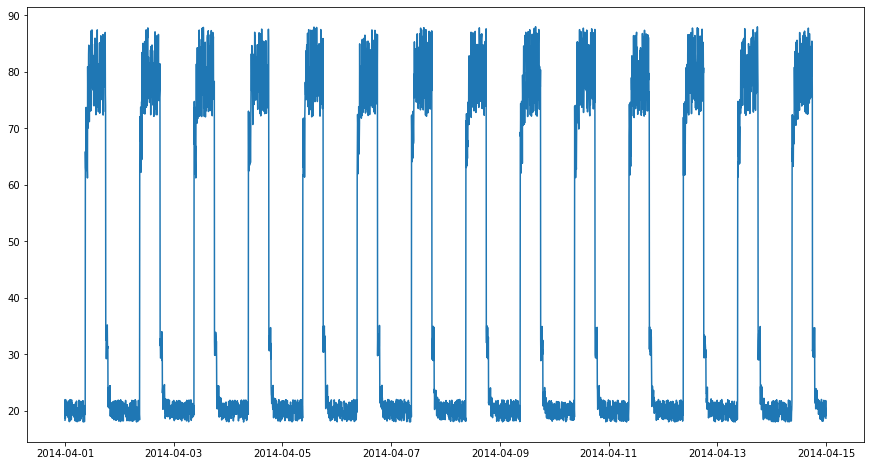

In [4]:
plt.figure(figsize=(15,8))
plt.plot(df_small_noise.value)
plt.show()

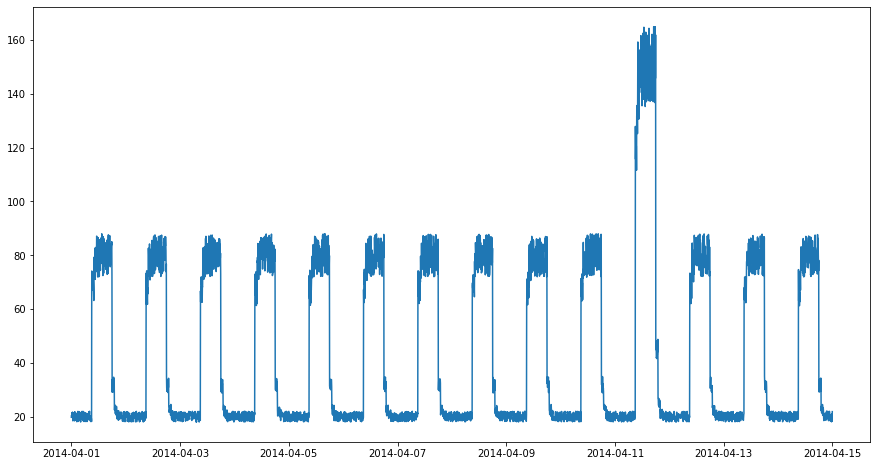

In [5]:
plt.figure(figsize=(15,8))
plt.plot(df_daily_jumpsup.value)
plt.show()

In [6]:
df_small_noise

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


In [7]:
# Standardize data for the NN

training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std

In [8]:
# Create sequence combining time_steps continguous data values from the training data

TIME_STEPS = 288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i+time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)
print(x_train.shape)

(3745, 288, 1)


In [61]:
# Build model
encoder = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=7,padding='same',strides=2,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Conv1D(filters=16,kernel_size=7,padding='same',strides=2,activation='relu')
])

decoder = keras.models.Sequential([
    keras.layers.Conv1DTranspose(filters=16,kernel_size=7,padding='same',strides=2,activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Conv1DTranspose(filters=32,kernel_size=7,padding='same',strides=2,activation='relu'),
    keras.layers.Conv1DTranspose(filters=1,kernel_size=7,padding='same')
])
autoencoder = keras.models.Sequential([encoder,decoder])
#encoder.summary()
#decoder.summary()
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='mse')
autoencoder.summary()

#model = keras.Sequential()
#model.add(Conv1D(filters=32,kernel_size=7,padding='same',strides=2,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
#model.add(Dropout(rate=0.2))
#model.add(Conv1D(filters=16,kernel_size=7,padding='same',strides=2,activation='relu'))
#model.add(Conv1DTranspose(filters=16,kernel_size=7,padding='same',strides=2,activation='relu'))
#model.add(Dropout(rate=0.2))
#model.add(Conv1DTranspose(filters=32,kernel_size=7,padding='same',strides=2,activation='relu'))
#model.add(Conv1DTranspose(filters=1,kernel_size=7,padding='same'))
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='mse')
#model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_36 (Sequential)   (None, 72, 16)            3856      
_________________________________________________________________
sequential_37 (Sequential)   (None, 288, 1)            5649      
Total params: 9,505
Trainable params: 9,505
Non-trainable params: 0
_________________________________________________________________


In [62]:
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)

history = autoencoder.fit(x_train,x_train,epochs=50,batch_size=128,validation_split=0.1,callbacks=callbacks)

Epoch 1/50
27/27 [==============================] - 1s 13ms/step - loss: 0.4471 - val_loss: 0.0563
Epoch 2/50
27/27 [==============================] - 0s 8ms/step - loss: 0.0773 - val_loss: 0.0427
Epoch 3/50
27/27 [==============================] - 0s 8ms/step - loss: 0.0568 - val_loss: 0.0327
Epoch 4/50
27/27 [==============================] - 0s 8ms/step - loss: 0.0485 - val_loss: 0.0282
Epoch 5/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0419 - val_loss: 0.0241
Epoch 6/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0366 - val_loss: 0.0215
Epoch 7/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0324 - val_loss: 0.0197
Epoch 8/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0295 - val_loss: 0.0187
Epoch 9/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0271 - val_loss: 0.0177
Epoch 10/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0251 - val_loss: 0.0170
Epoch 11/50
27/27 

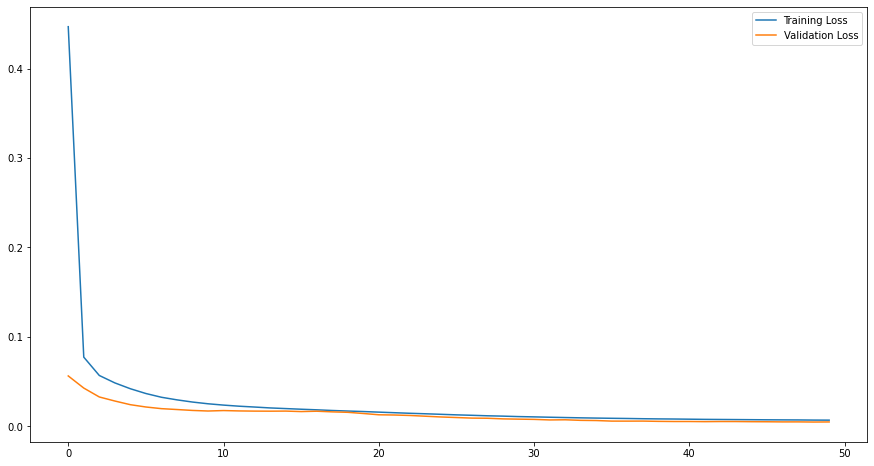

In [63]:
plt.figure(figsize=(15,8))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

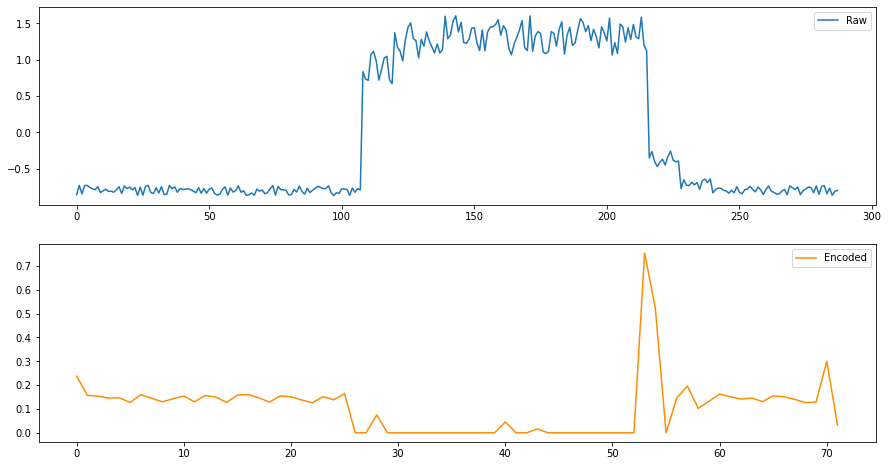

In [64]:
# Looking at the encoder
x_encoded = encoder.predict(x_train)

plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(x_train[0,:,0])
plt.legend(['Raw'])
plt.subplot(2,1,2)
plt.plot(x_encoded[0,:,0],color='darkorange')
plt.legend(['Encoded'])
plt.show()

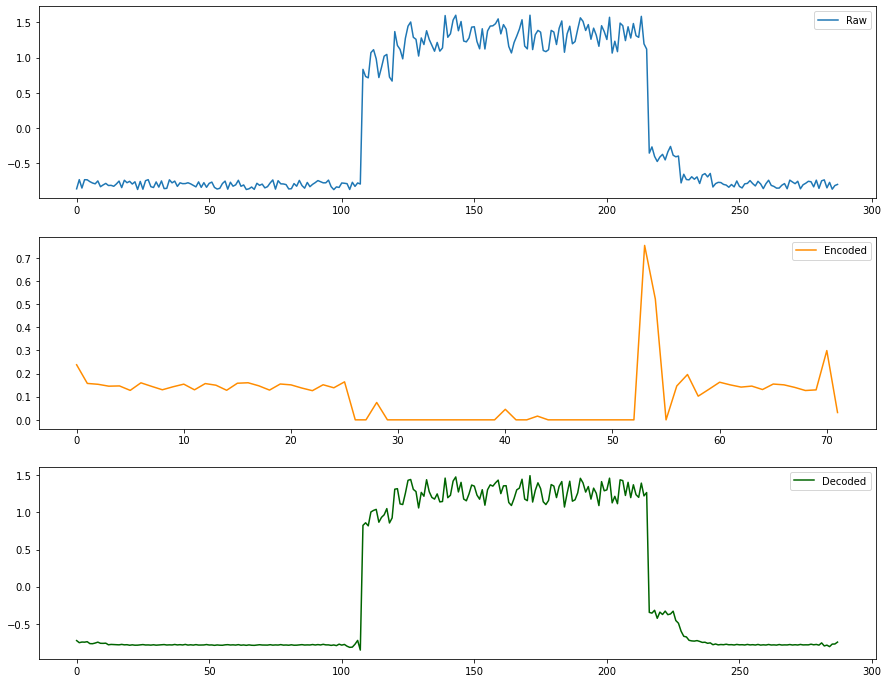

In [65]:
x_train_pred = autoencoder.predict(x_train)

plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.plot(x_train[0,:,0])
plt.legend(['Raw'])
plt.subplot(3,1,2)
plt.plot(x_encoded[0,:,0],color='darkorange')
plt.legend(['Encoded'])
plt.subplot(3,1,3)
plt.plot(x_train_pred[0,:,0],color='darkgreen')
plt.legend(['Decoded'])
plt.show()

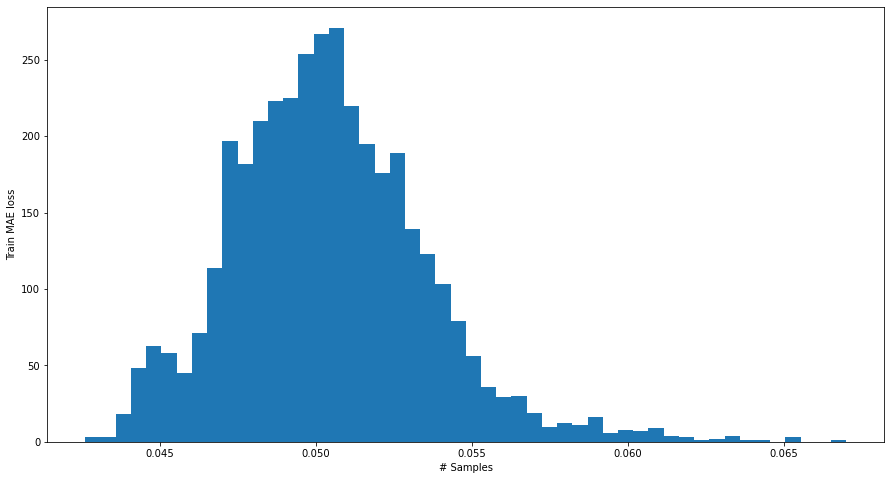

0.06700875166071443


In [68]:
# Detecting anomalies

train_mae_loss = np.mean(np.abs(x_train_pred - x_train),axis=1)
plt.figure(figsize=(15,8))
plt.hist(train_mae_loss, bins=50)
plt.xlabel('# Samples')
plt.ylabel('Train MAE loss')
plt.show()

# Get reconstruction loss threshold
threshold = np.max(train_mae_loss)
print(threshold)

In [80]:
df_x_test = (df_daily_jumpsup - training_mean) / training_std
x_test = create_sequences(df_x_test.values)
x_test_pred = autoencoder.predict(x_test)

In [81]:
# Get MAE Loss
test_mae_loss = np.mean(np.abs(x_test_pred - x_test),axis=1)
test_mae_loss = test_mae_loss.reshape(-1)
anomalies = test_mae_loss > threshold
print(np.sum(anomalies))

403


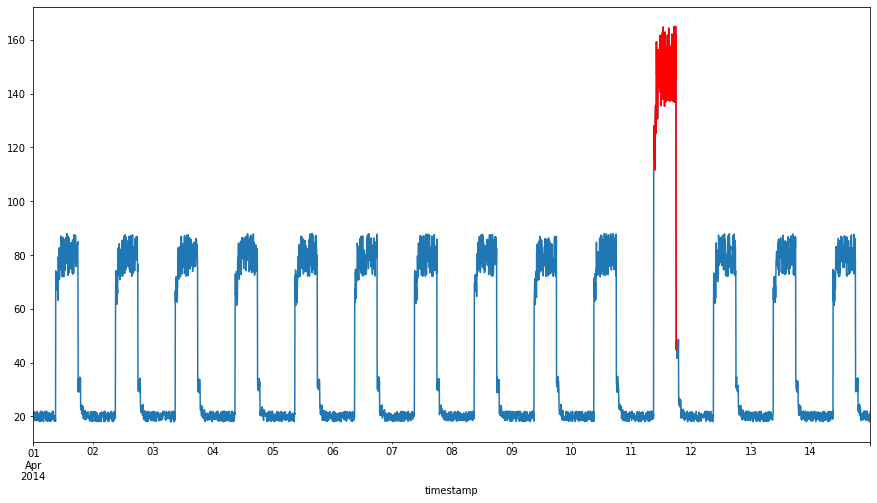

In [84]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_x_test) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
        
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(15,8))
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()